In [1]:
# if this doesn't work you'll need to downgrade flake8
# pip install -Iv flake8==3.9.2
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Send a Flipbook of Variable Stars Images to Zooniverse</b> <br>
Author(s): Becky Nevin and Sreevani Jarugula <br>
Contact author: Becky Nevin<br>
Last verified to run: 2024-01-04 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container size: small or medium <br>
Targeted learning level: intermediate

**Description:**
Query and send a flipbook of variable star images from RSP to Zooniverse

**Skills:** Use various TAP tables, including joining multiple tables. Get calexp images. Extract time-series photometry.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.MatchesTruth, TruthSummary, ForcedSource, CcdVisit<br>

**Packages:** rubin.cistci, astropy, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Tutorial notebooks 03a, 04a, 04b, 07b, and 08

**Support:** Support is available and questions are welcome - (cscience@lsst.org)

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook will guide a PI through the process of sending a flipbook of images of a variable star from the Rubin Science Platform (RSP) to the Zooniverse.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
Note that this package will soon be installed directly on RSP.

4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

In [4]:
from rubin.citsci import pipeline
import utils
import gc
import numpy as np
import pandas as pd
import os
import astropy
from astropy.wcs import WCS
from astropy import units as u
import lsst.geom as geom
import matplotlib
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import lsst.afw.display as afwdisplay
afwdisplay.setDefaultBackend("matplotlib")

### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
If you haven't already, [make a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 

Supply the email associated with your Zooniverse account and project slug below.

A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).


In [6]:
email = "beckynevin@gmail.com"
slug_name = "rebecca-dot-nevin/test-project"
print("Running utilities to establish a link with Zooniverse")
print("Enter your Zooniverse username followed by password below")
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(slug_name, email)

Running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Enter your Zooniverse credentials...


Username:  rebecca.nevin
 ········


You now are logged in to the Zooniverse platform.


## 2. Make a subject set of a variable star to send to Zooniverse <a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

This notebook curates a subject set of flipbook images from a variable star to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes one set of image cutouts of a confirmed variable star at five different moments in time.

### 2.1 Initialize the Butler

In [7]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
service, butler, skymap = utils.setup_butler(config, collection)

### 2.2 Get familiar with the DiaObject and ForcedSourceOnDiaObject tables
This includes the DiaObject table and the ForcedSourceOnDiaObject table. Note that these are _difference_ image tables, created by identifying objects not present in the template deepcoadd images. For more information, see https://lse-163.lsst.io/.


In [8]:
pd.set_option('display.max_rows', 200, 'display.max_colwidth', 1000)
results_diaobject = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.DiaObject'")

In [9]:
results_diaobject.to_table().to_pandas()

,column_name,datatype,description,unit
0,decl,double,Mean Declination of DIASources in the diaObject,deg
1,diaObjectId,long,Unique id.,
2,gPSFluxChi2,double,Chi^2 statistic for the scatter of gPSFlux around gPSFluxMean,
3,gPSFluxErrMean,double,Mean of the diaSource PSF flux errors,
4,gPSFluxLinearIntercept,double,y-intercept of a linear model fit to diaSource PSF flux vs time,
5,gPSFluxLinearSlope,double,Slope of a linear model fit to diaSource PSF flux vs time,
6,gPSFluxMAD,double,Median absolute deviation of diaSource PSF flux. Does not include scale factor for comparison to sigma,
7,gPSFluxMax,double,Maximum diaSource PSF flux,
8,gPSFluxMaxSlope,double,Maximum ratio of time ordered deltaFlux / deltaTime,
9,gPSFluxMean,double,Weighted mean of diaSource PSF flux,


diaObjectId is the unique ID for each object in the table; note that these are different IDs from the ObjectId in the Object table. From https://lse-163.lsst.io/:

>There is no direct DIASource-to-Object match: in general, a time-domain object is not necessarily the same astrophysical object as a static-sky object, even if the two are positionally coincident (eg. an asteroid overlapping a galaxy). Therefore, adopted data model emphasizes that having a DIASource be positionally coincident with an Object does not imply it is physically related to it. Absent other information, the least presumptuous data model relationship is one of positional association, not physical identity.

It is also necessary to have visit information to create images for each visit. Obtain visit information from the ForcedSourceOnDiaObject table (below). 

In [11]:
results_forceddiaobject = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = \
                          'dp02_dc2_catalogs.ForcedSourceOnDiaObject'")

In [12]:
results_forceddiaobject.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Abstract filter that is not associated with a particular instrument,
1,ccdVisitId,long,Unique ID of visit and detector for which forced photometry was performed. Primary Key of the CcdVisit Table.,
2,coord_dec,double,Fiducial ICRS Declination of DiaObject centroid used for database indexing,deg
3,coord_ra,double,Fiducial ICRS Right Ascension of DiaObject centroid used for database indexing,deg
4,diaObjectId,long,Unique DiaObject ID. Primary Key of the DiaObject Table,
5,forcedSourceOnDiaObjectId,long,Unique ID of forced source. Primary Key.,
6,localBackground_instFlux,double,Background in annulus around source,count
7,localBackground_instFluxErr,double,1-sigma uncertainty on the background in an annulus around source,count
8,localPhotoCalib,double,Local approximation of the PhotoCalib calibration factor at the location of the src.,
9,localPhotoCalib_flag,boolean,Set for any fatal failure,


Finally, examine the CcdVisit catalog, which is matched with the ForcedSourceOnDiaObject catalog in order to retrieve timing information of when the exposure was taken.

In [13]:
results_ccdvisit = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'")

In [14]:
results_ccdvisit.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure where this source was measured. Abstract filter that is not associated with a particular instrument.,
1,ccdVisitId,long,Primary key (unique identifier).,
2,darkTime,double,"Average dark current accumulation time, accurate to 10ms.",s
3,decl,double,Declination of Ccd center.,deg
4,detector,long,Detector ID. A detector associated with a particular instrument (not an observation of that detector),
5,expMidpt,char,"Midpoint for exposure. TAI, accurate to 10ms.",
6,expMidptMJD,double,"Midpoint for exposure in MJD. TAI, accurate to 10ms.",d
7,expTime,double,"Spatially-averaged duration of exposure, accurate to 10ms.",s
8,llcdec,double,Declination of lower left corner.,deg
9,llcra,double,RA of lower left corner.,deg


In [15]:
del results_forceddiaobject, results_diaobject, results_ccdvisit

### 2.3 Do a search for variable stars
Perform this search by joining the three catalogs explored above.

For more details, please see the `DP02_07b_Variable_Star_Lightcurves.ipynb` notebook in the tutorial notebooks by Jeff Carlin and Ryan Lau. All the code in this section is derivative of that notebook.

Use the coordinates of a known variable star.

In [16]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

This query will return a massive list of sources, some of which are repeat object IDs.

In [19]:
query = "SELECT diao.diaObjectId, "\
        "fsodo.forcedSourceOnDiaObjectId, "\
        "diao.ra, diao.decl, "\
        "diao.gPSFluxNdata, "\
        "diao.gPSFluxStetsonJ, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as psfMag, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "cv.expMidptMJD, cv.detector, cv.visitId, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv "\
        "ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
fsodo_sources = results.to_table()
fsodo_sources

diaObjectId,forcedSourceOnDiaObjectId,ra,decl,gPSFluxNdata,gPSFluxStetsonJ,gTOTFluxMean,gTOTFluxSigma,psfMag,diaObjectId2,ccdVisitId,band,psfFlux,psfFluxErr,psfDiffFlux,psfDiffFluxErr,expMidptMJD,detector,visitId,fsodo_gmag
,,deg,deg,,,,,,,,,nJy,nJy,nJy,nJy,d,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,int64,int64,float64
1568950316278219135,355690962002903599,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,17.864033402419253,1568950316278219135,662526045,g,259648.9908643,423.7730634,-219051.1495052,432.8655653,60560.2826042,45,662526,17.864033402419253
1568950316278219135,103713865241461849,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,19.063114664924566,1568950316278219135,193182128,r,86050.645805,298.5169185,-14602.9136397,303.6819171,59839.3507772,128,193182,19.063114664924566
1568950316278219135,226363652880469256,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,18.678994269516238,1568950316278219135,421635160,i,122575.1101511,390.8119071,5140.6030076,404.1377577,60180.3021012,160,421635,18.678994269516238
1568950316278219135,146708080233548429,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,18.29759788250864,1568950316278219135,273265094,z,174164.9851142,629.2273185,-19325.1093435,656.5473992,59963.0594742,94,273265,18.29759788250864
1568950316278219135,372739324120141658,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,19.51963739298456,1568950316278219135,694281094,r,56512.5680246,264.42331,-21719.446721,299.0289831,60605.3311952,94,694281,19.51963739298456
1568950316278219135,506936602707100152,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,19.066762363258093,1568950316278219135,944243004,g,85762.0304762,248.0646447,-274851.3347688,291.5739513,60962.2864662,4,944243,19.066762363258093
1568950316278219135,488489257535537224,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,18.090302320392844,1568950316278219135,909882146,r,210804.1089703,421.7247573,49089.868058,424.0791348,60905.3538062,146,909882,18.090302320392844
1568950316278219135,623081735390757741,67.2951662,-38.4159654,40.0,43.70482,79866.3822305,30506.3324512,18.491011649240875,1568950316278219135,1160580172,i,145745.5623625,514.6744102,-11480.9651446,518.4510104,61277.3678392,172,1160580,18.491011649240875


List by unique source instead.

In [21]:
select_cols = ['diaObjectId',
               'ra',
               'decl',
               'expMidptMJD',
               'band',
               'ccdVisitId',
               'visitId',
               'detector']
unique_variables = astropy.table.unique(fsodo_sources,
                                        keys='diaObjectId')[select_cols]
unique_variables

diaObjectId,ra,decl,expMidptMJD,band,ccdVisitId,visitId,detector
,deg,deg,d,,,,
int64,float64,float64,float64,object,int64,int64,int64
1567428592185376787,59.4814837,-37.7323315,61254.3419842,y,1141195101,1141195,101
1567762843720221100,62.5202159,-37.8646632,60280.2057552,r,480303131,480303,131
1568246628836442456,62.5202159,-37.8646632,61017.0802592,g,975962163,975962,163
1568950316278219135,67.2951662,-38.4159654,60560.2826042,g,662526045,662526,45
1569082257673552562,67.0155078,-37.8278368,59914.1755432,r,242558012,242558,12
1569135034231685181,67.4679316,-37.6786425,60275.0778372,z,476393014,476393,14
1651510445384663056,62.6536501,-35.9700212,60185.3811712,z,426670023,426670,23
1651589610221862935,62.1479038,-35.7991348,60540.4073132,y,646739066,646739,66


### 2.4 Select one variable star
Select one pre-selected diaobjectID. It is possible to select another, but for the purposes of this tutorial this is not recommended because many of these sources are not true variable stars.

In [25]:
diaobjectid = 1567428592185376787
selection = unique_variables[unique_variables["diaObjectId"] == diaobjectid]
ra = selection['ra'].value[0]
dec = selection['decl'].value[0]
print('ra and dec of variable star', ra, dec)

ra and dec of variable star 59.4814837 -37.7323315


### 2.5 Select some moments in time
To do this, go back to the original table to get all of the necessary information necessary to plot a series of images, including visit information.

In [28]:
columns_select = ['diaObjectId',
                  'ra',
                  'decl',
                  'ccdVisitId',
                  'visitId',
                  'band',
                  'psfFlux',
                  'psfFluxErr',
                  'expMidptMJD',
                  'detector',
                  'psfMag']
source = fsodo_sources[fsodo_sources["diaObjectId"] ==
                       diaobjectID][columns_select]
source

diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,1141195101,1141195,y,217274.9132152,1755.4059358,61254.3419842,101,18.05747603718028
1567428592185376787,59.4814837,-37.7323315,1212153079,1212153,i,220985.9696981,590.3284039,61364.2925662,79,18.039088246512566
1567428592185376787,59.4814837,-37.7323315,662532066,662532,g,196440.0949505,433.4549124,60560.2854312,66,18.16692466155384
1567428592185376787,59.4814837,-37.7323315,909782131,909782,r,195614.2995458,482.6527048,60905.3085432,131,18.171498502873554
1567428592185376787,59.4814837,-37.7323315,1047475123,1047475,z,275528.8518518,935.3058406,61118.0144062,123,17.799582293809436
1567428592185376787,59.4814837,-37.7323315,904789050,904789,y,283345.1047675,1523.756618,60899.4044252,50,17.769210715195413
1567428592185376787,59.4814837,-37.7323315,676185120,676185,r,209555.5588523,490.1820967,60583.3096732,120,18.09675203551415
1567428592185376787,59.4814837,-37.7323315,266167081,266167,y,289677.4273541,1792.3334894,59950.1359082,81,17.74521336293549


Create a function that will select by band.


In [30]:
plot_band_labels = ['u', 'g', 'r', 'i', 'z', 'y']
pick = {}
for band in plot_band_labels:
    pick[band] = (source['band'] == band)

From now on, select only the r-band images. Also order by date.

In [31]:
print(type(source[pick['r']]))
select_r = source[pick['r']]
sorted_sources = select_r[select_r['expMidptMJD'].argsort()]
sorted_sources

<class 'astropy.table.table.Table'>


diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,40327030,40327,r,258575.9147688,535.0198784,59634.0870892,30,17.86852982557396
1567428592185376787,59.4814837,-37.7323315,193147032,193147,r,207715.9826285,497.251246,59839.3340712,32,18.10632521388235
1567428592185376787,59.4814837,-37.7323315,193148018,193148,r,208104.7777051,490.872577,59839.3345202,18,18.1042948726672
1567428592185376787,59.4814837,-37.7323315,193187002,193187,r,202320.5385648,491.5006487,59839.3530702,2,18.134900068992444
1567428592185376787,59.4814837,-37.7323315,193848097,193848,r,232671.7968929,499.4616498,59840.2471442,97,17.983140640366102
1567428592185376787,59.4814837,-37.7323315,202591070,202591,r,380253.6030788,636.4953924,59854.2787212,70,17.44981665528585
1567428592185376787,59.4814837,-37.7323315,202617009,202617,r,379673.378463,646.3810577,59854.2941412,9,17.451474632986304
1567428592185376787,59.4814837,-37.7323315,202618104,202618,r,379051.7059444,643.7650345,59854.2945992,104,17.45325386113064


Select some random moments in time. Keep these the same to observe a change in brightness, or select your own *at your own risk*.

In [33]:
idx_select = [10, 15, 25, 40, 63]

Show the selected moments against all dates.

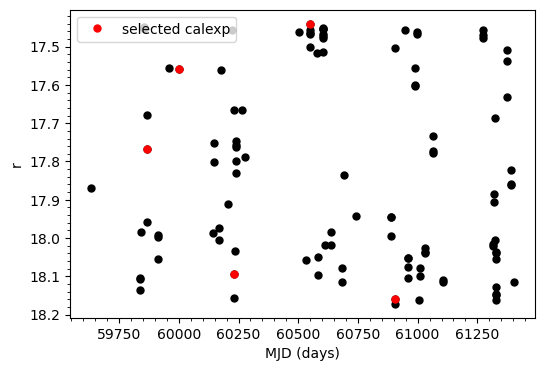

In [36]:
fig = plt.figure(figsize=(6, 4))
plt.plot(sorted_sources['expMidptMJD'],
         sorted_sources['psfMag'],
         'k.', ms=10)
plt.plot(sorted_sources[idx_select]['expMidptMJD'],
         sorted_sources[idx_select]['psfMag'],
         'r.', ms=10, label='selected calexp')
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.gca().invert_yaxis()
plt.legend(loc=2)
plt.show()

### 2.6 Save images and write the `manifest.csv` to file
Below are some utility functions.

In [86]:
def update_wcs_center(wcs, new_center_sky):
    """
    Update the CRVAL values in the FITS header

    Parameters
    ----------
    wcs: world coordinate system from calexp image from lsst.butler
    new_center_sky: new coordinate center

    Returns
    -------
    updated WCS
    """
    header = wcs.getFitsMetadata()
    header['CRVAL1'] = new_center_sky.getLongitude().asDegrees()
    header['CRVAL2'] = new_center_sky.getLatitude().asDegrees()
    new_wcs = WCS(header)
    return new_wcs


def set_wcs_ticks_labels(ax, wcs):
    """
    Explicitly set tick positions and labels for the WCS axes
    d. is degrees and .dd is the number of decimal points to display

    Parameters
    ----------
    ax: axes object
    wcs: world coordinate system from calexp image from lsst.butler

    Returns
    -------
    updated axes labels and tick positions
    """
    ax.coords[0].set_major_formatter('d.ddd')
    # positions on bottom left
    ax.coords[0].set_ticks_position('bl')
    ax.coords[0].set_axislabel('Right Ascension')

    ax.coords[1].set_major_formatter('d.ddd')
    ax.coords[1].set_ticks_position('bl')
    ax.coords[1].set_axislabel('Declination')

    # Set the maximum number of ticks for both axes
    ax.coords[0].set_ticks(spacing=2*u.arcsec)
    ax.coords[1].set_ticks(spacing=2*u.arcsec)


# from tutorial 03a:
def cutout_calexp(butler,
                  ra,
                  dec,
                  visit,
                  detector,
                  cutoutsidelength=51,
                  **kwargs):
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutsidelength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage: cutout image
    """
    dataid = {'visit': visit, 'detector': detector}
    print('ra', ra, 'dec', dec)
    radec = geom.SpherePoint(ra,
                             dec,
                             geom.degrees)
    cutoutsize = geom.ExtentI(cutoutsidelength,
                              cutoutsidelength)
    calexp_wcs = butler.get('calexp.wcs',
                            **dataid)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutsize // 2,
                     cutoutsize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp',
                              parameters=parameters,
                              **dataid)
    return cutout_image


def make_calexp_fig(cutout_image, out_name):
    """
    Create a figure of a calexp image
    should be followed with remove_figure

    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    out_name : file name where you'd like to save it

    Returns
    ----------
    cutout figure
    """
    
    # Extract the WCS from the cutout image
    wcs = cutout_image.getWcs()
    
    # Get the CRVAL values from the WCS metadata
    crval1 = wcs.getFitsMetadata()['CRVAL1']
    crval2 = wcs.getFitsMetadata()['CRVAL2']
    # Create a new SpherePoint for the center of the image
    center_sky = geom.SpherePoint(crval1,
                                  crval2,
                                  geom.degrees)
    # Modify the center (for example, shift by 1 degree)
    new_center_sky = geom.SpherePoint(center_sky.getLongitude(),
                                      #+ 1.0*geom.degrees,
                                      center_sky.getLatitude())
                                      #+ 1.0*geom.degrees)
    # Update the WCS with the new center
    new_wcs = update_wcs_center(wcs,
                                new_center_sky)
    

    fig = plt.figure()
    ax = plt.subplot(projection=new_wcs)
    calexp_extent = (cutout_image.getBBox().beginX,
                     cutout_image.getBBox().endX,
                     cutout_image.getBBox().beginY,
                     cutout_image.getBBox().endY)
    im = ax.imshow(abs(cutout_image.image.array),
                   cmap='gray',
                   extent=calexp_extent,
                   origin='lower',
                   norm=matplotlib.colors.LogNorm(vmin=1e1, vmax=1e5)
                   )
    plt.colorbar(im, location='right', anchor=(0, 0.1))
    set_wcs_ticks_labels(ax, new_wcs)
    #plt.axis('off')
    plt.savefig(out_name)
    print('shape of image', np.shape(cutout_image.image.array))
    return fig


def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()
    plt.close(fig)
    gc.collect()

Define the directory where the flipbook images will be saved (`batch_dir`). Then running through the list of moments in time, create calexp images, and add a row to the manifest file for each image.

ra 59.4814837 dec -37.7323315
shape of image (50, 50)


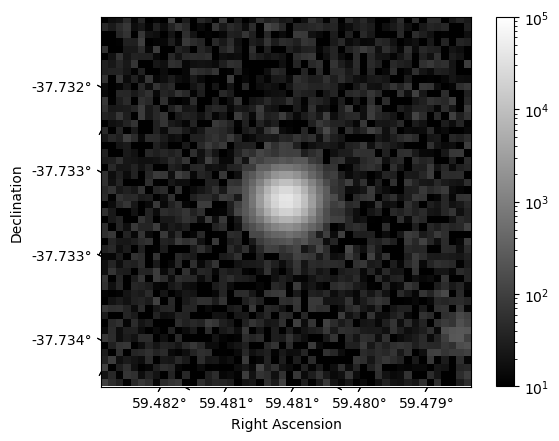

ra 59.4814837 dec -37.7323315
shape of image (50, 50)


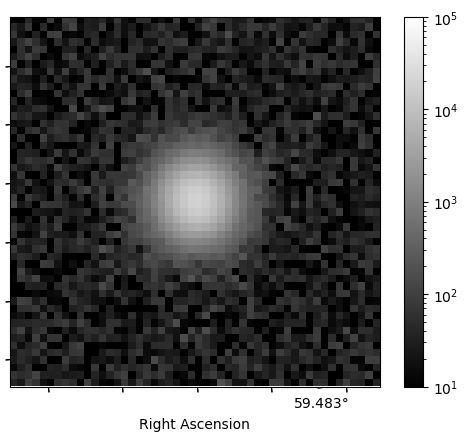

ra 59.4814837 dec -37.7323315
shape of image (50, 50)


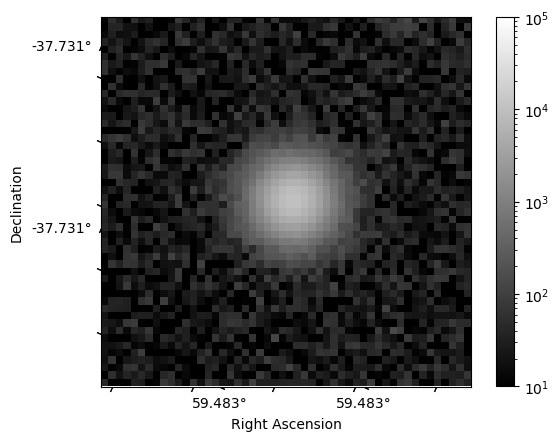

ra 59.4814837 dec -37.7323315
shape of image (50, 50)


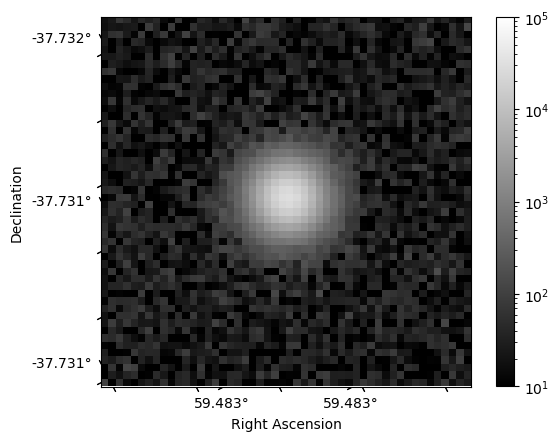

ra 59.4814837 dec -37.7323315
shape of image (50, 50)


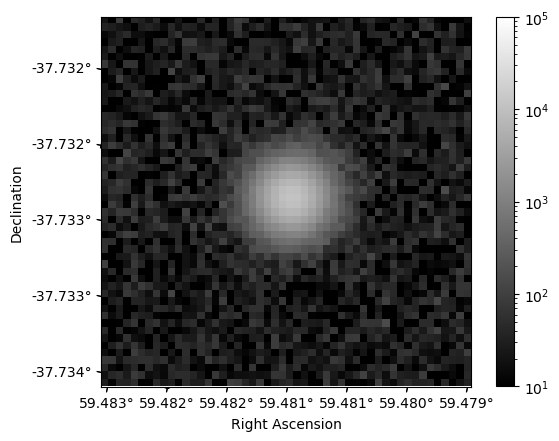

In [87]:
batch_dir = './variable_stars_output/'
figout_data = {"sourceId": diaobjectid}
cutouts = []

for i, idx in enumerate(idx_select):
    star_ra = sorted_sources['ra'][idx]
    star_dec = sorted_sources['decl'][idx]
    star_visitid = sorted_sources['visitId'][idx]
    star_detector = sorted_sources['detector'][idx]
    star_id = sorted_sources['diaObjectId'][idx]
    star_ccdid = sorted_sources['ccdVisitId'][idx]
    calexp_image = cutout_calexp(butler,
                                 star_ra,
                                 star_dec,
                                 star_visitid,
                                 star_detector,
                                 50)
    figout = make_calexp_fig(calexp_image,
                             batch_dir + "/images/" +
                             str(star_id) + "_" +
                             str(star_ccdid) + ".png")
    plt.show()
    remove_figure(figout)
    figout_data['location:image_'+str(i)] = str(star_id) + \
        "_" + str(star_ccdid) + ".png"
    figout_data['diaObjectId:image_'+str(i)] = str(star_id)
    figout_data['filename'] = str(star_id) + "_" + str(star_ccdid) + ".png"

df_manifest = pd.DataFrame(data=figout_data, index=[0])
outfile = batch_dir + "images/manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')

### 2.7 Display images in notebook
Display the images saved to the manifest file using the image directory (`batch_dir`).

In [ ]:
image_dir = batch_dir + 'images/'
num_variable_images = 5
stars_matchid_list = [diaobjectID]

star_name = np.zeros((1, num_variable_images))
star_name = []
for i, id_star in enumerate(stars_matchid_list):
    # go through and sort by ccdID so that they are in order of time
    # DOUBLE CHECK THAT THIS IS TIME ORDER
    ccdID_list = []
    for j, file in enumerate(os.listdir(image_dir)):
        if str.split(file,'.')[1] == 'png' and str.split(file,'_')[0] == str(id_star):
            star_name.append(str(id_star)+'_'+str(int(str.split(str.split(file,'_')[1],'.')[0]))+'.png')

fig, axs = plt.subplots(1,5, figsize = (20,20))
print('star', stars_matchid_list[0])
for j in range(num_variable_images):
    image = mpimg.imread(image_dir + star_name[j])
    axs[j].imshow(image)#, norm = matplotlib.colors.LogNorm())
    axs[j].axis('off')
plt.show()

try:
    print('star', stars_matchid_list[1])
    fig, axs = plt.subplots(1,5, figsize = (20,20))

    for j in range(num_variable_images):
        image = mpimg.imread(image_dir + star_name[j+num_variable_images])
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()

except IndexError: # which will happen if you have only one star
    print('only one star')


The third and fifth image should be the brightest.

### A word of caution
These are calexp images, which have not been aligned like individual visits that are combined in a deepcoadd image. Therefore, the pixelscale is not guaranteed to be the same from one image to the next and the astrometry is not guaranteed to align. 

## 3. Send the data to Zooniverse
This cell will let PIs send one subject set. Name the subject set as it will appear on Zooniverse.

In [ ]:
cutout_dir = batch_dir+"images/"
subject_set_name = "test_flipbook" 
cit_sci_pipeline.send_image_data(subject_set_name, cutout_dir)